In [3]:
import brian2 as b2
from neurodynex3.leaky_integrate_and_fire import LIF
from neurodynex3.tools import input_factory, plot_tools

In [3]:
LIF.ABSOLUTE_REFRACTORY_PERIOD = 3 * b2.ms

In [4]:
I_min_values = [i * b2.namp for i in [0, 20, 40, 60, 80, 100]]
# create a step current with amplitude = I_min
step_currents = [input_factory.get_step_current(
    t_start=5, t_end=500, unit_time=b2.ms,
    amplitude=I_min_values[i]) for i in range(6)]

In [ ]:
step_current = step_currents[5]

# run the LIF model.
# Note: As we do not specify any model parameters, the simulation runs with the default values
(state_monitor,spike_monitor) = LIF.simulate_LIF_neuron(
                                    input_current=step_current,
                                    simulation_time = 50 * b2.ms)

# plot I and vm
plot_tools.plot_voltage_and_current_traces(
state_monitor, step_current, title="Zero Input", firing_threshold=LIF.FIRING_THRESHOLD)
print("nr of spikes: {}".format(spike_monitor.count[0]))  # should be 0

In [ ]:
# get a random parameter. provide a random seed to have a reproducible experiment
random_parameters = LIF.get_random_param_set(random_seed=42)

# define your test current
test_current = input_factory.get_step_current(
    t_start=5, t_end=50, unit_time=b2.ms, amplitude= 10 * b2.namp)

# probe the neuron. pass the test current AND the random params to the function
state_monitor, spike_monitor = LIF.simulate_random_neuron(test_current, random_parameters)

# plot
plot_tools.plot_voltage_and_current_traces(state_monitor, test_current, title="experiment")

# print the parameters to the console and compare with your estimates
# LIF.print_obfuscated_parameters(random_parameters)

In [21]:
LIF.print_obfuscated_parameters(random_parameters)

Resting potential: -0.07200000000000001
Reset voltage: -0.082
Firing threshold: -0.023
Membrane resistance: 5000000.0
Membrane time-scale: 0.009000000000000001
Absolute refractory period: 0.002


nr of spikes: 0


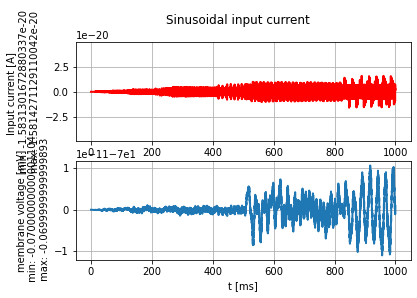

In [76]:
# note the higher resolution when discretizing the sine wave: we specify unit_time=0.1 * b2.ms
sinusoidal_current = input_factory.get_sinusoidal_current(50, 10000, unit_time=0.1 * b2.ms,
                                            amplitude= 2.5 * b2.namp, frequency=5000*b2.Hz,
                                            direct_current=0. * b2.namp)

# run the LIF model. By setting the firing threshold to to a high value, we make sure to stay in the linear (non spiking) regime.
(state_monitor, spike_monitor) = LIF.simulate_LIF_neuron(input_current=sinusoidal_current, simulation_time = 1000 * b2.ms, firing_threshold=0*b2.mV)

# plot the membrane voltage
plot_tools.plot_voltage_and_current_traces(state_monitor, sinusoidal_current, title="Sinusoidal input current")
print("nr of spikes: {}".format(spike_monitor.count[0]))


In [1]:
import matplotlib.pyplot as plt
from neurodynex3.cable_equation import passive_cable
from neurodynex3.tools import input_factory

In [5]:
test_current = input_factory.get_step_current(
    t_start=1000, t_end=1100, unit_time=b2.us, amplitude= 0.8 * b2.namp)
voltage_monitor, cable_model = passive_cable.simulate_passive_cable(
                                current_injection_location=[200*b2.umetre],
                                input_current=test_current,
                                length=800 * b2.umetre)
probe_location = 0.123 * b2.mm
v = voltage_monitor[cable_model.morphology[probe_location]].v

In [ ]:
#plt.plot(voltage_monitor.t / b2.ms, voltage_monitor[0].v / b2.mV)
plt.imshow(voltage_monitor.v / b2.volt)

In [ ]:
t_spikes = [10, 15, 20]
l_spikes = [100. * b2.um, 200. * b2.um, 300. * b2.um]
current = input_factory.get_spikes_current(t_spikes, 100*b2.us, 0.8*b2.namp, append_zero=True)
voltage_monitor_ABC, cable_model = passive_cable.simulate_passive_cable(
                                        current_injection_location=l_spikes,
                                        input_current=current,
                                        length=800 * b2.umetre)
plt.imshow(voltage_monitor_ABC.v / b2.volt)

In [ ]:
t_spikes = [5]
l_spikes = [400 * b2.um]
current = input_factory.get_spikes_current(t_spikes, 10*b2.us, 0.8*b2.namp, append_zero=True)
voltage_monitor_ABC, cable_model = passive_cable.simulate_passive_cable(
                                        current_injection_location=l_spikes,
                                        input_current=current,
                                        length=800 * b2.umetre)

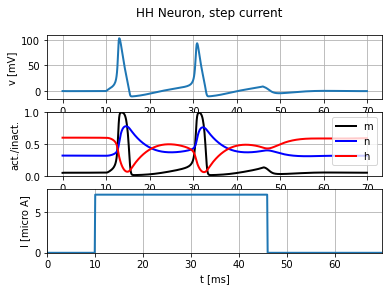

In [1]:
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex3.hodgkin_huxley import HH
from neurodynex3.tools import input_factory

HH.getting_started()

In [44]:
def fake_sim(input_current, simulation_time):

    """A Hodgkin-Huxley neuron implemented in Brian2.

    Args:
        input_current (TimedArray): Input current injected into the HH neuron
        simulation_time (float): Simulation time [seconds]

    Returns:
        StateMonitor: Brian2 StateMonitor with recorded fields
        ["vm", "I_e", "m", "n", "h"]
    """

    # neuron parameters
    El = 10.6 * b2.mV
    EK = -12 * b2.mV
    ENa = 115 * b2.mV
    gl = 0.3 * b2.msiemens
    gK = 36 * b2.msiemens
    gNa = 120 * 3 * b2.msiemens
    C = 1 * b2.ufarad

    # forming HH model with differential equations
    eqs = """
    I_e = input_current(t,i) : amp
    membrane_Im = I_e + gNa*m**3*h*(ENa-vm) + \
        gl*(El-vm) + gK*n**4*(EK-vm) : amp
    alphah = .07*exp(-.05*vm/mV)/ms    : Hz
    alpham = .1*(25*mV-vm)/(exp(2.5-.1*vm/mV)-1)/mV/ms : Hz
    alphan = .01*(10*mV-vm)/(exp(1-.1*vm/mV)-1)/mV/ms : Hz
    betah = 1./(1+exp(3.-.1*vm/mV))/ms : Hz
    betam = 4*exp(-.0556*vm/mV)/ms : Hz
    betan = .125*exp(-.0125*vm/mV)/ms : Hz
    dh/dt = alphah*(1-h)-betah*h : 1
    dm/dt = alpham*(1-m)-betam*m : 1
    dn/dt = alphan*(1-n)-betan*n : 1
    dvm/dt = membrane_Im/C : volt
    """

    neuron = b2.NeuronGroup(1, eqs, method="exponential_euler")

    # parameter initialization
    neuron.vm = 0
    neuron.m = 0.05
    neuron.h = 0.60
    neuron.n = 0.32

    # tracking parameters
    st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "m", "n", "h"], record=True)

    # running the simulation
    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)

    return st_mon


WARNING    /Users/abhinavmenon/opt/anaconda3/lib/python3.9/site-packages/neurodynex3/hodgkin_huxley/HH.py:61: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.axis((
 [py.warnings]


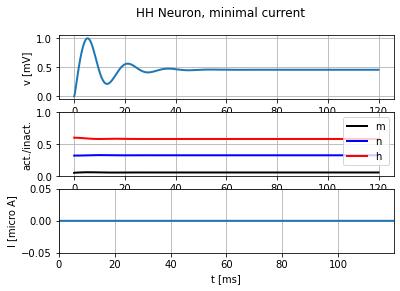

In [56]:
current = input_factory.get_step_current(5, 100, b2.ms, 0 *b2.uA)
state_monitor = fake_sim(current, 120 * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron, minimal current")